<a href="https://colab.research.google.com/github/KyleEtera/MAT422/blob/main/3_7_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**3.7.1 Mathematical Formulation** - To get our output $\hat{y}$, we take in our inputs, $x_1$ and $x_2$, and modify them by an activation function $\sigma(z)$ chosen in advance with weights, $w_i$, and bias, $b$, determined algorithmically to best fit our given data.
$$\hat{y} =\sigma (z) =\sigma (w_1a_1+w_2a_2+b).$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import sklearn

In [3]:
X = np.array([[1,0],[1,-1],[0,1]])
y = np.array([1, 1, 0])

In [4]:
def initialize_parameters(layer_dim):
    np.random.seed(100)
    parameters = {}
    Length = len(layer_dim)

    for i in range(1,Length):
        parameters['w'+str(i)]=np.random.rand(layer_dim[i],layer_dim[i-1])*0.1
        parameters['b'+str(i)]=np.zeros((layer_dim[i],1))

    return parameters

# Test
test_parameters=initialize_parameters([2,2,1])
print(test_parameters)

{'w1': array([[0.05434049, 0.02783694],
       [0.04245176, 0.08447761]]), 'b1': array([[0.],
       [0.]]), 'w2': array([[0.00047189, 0.01215691]]), 'b2': array([[0.]])}


In [7]:
def sigmoid(x):
    return(1/(1+np.exp(-x)))

def relu(x):
    return(np.maximum(0,x))

def single_layer_forward_propagation(x,w_cur,b_cur,activation):
    z=np.dot(w_cur,x)+b_cur
    if activation == 'relu':
        a = relu(z)
    elif activation == 'sigmoid':
        a = sigmoid(z)
    else:
        raise Exception('Not supported activation function')

    return z, a

def full_forward_propagation(x,parameters):
    caches = {}
    caches['a0']=X.T

    A_prev=x
    Length=len(parameters)//2

    for i in range(1,Length):
        z, a = single_layer_forward_propagation(A_prev,parameters['w'+str(i)],parameters['b'+str(i)],'relu')
        caches['z' + str(i)] = z
        caches['a' + str(i)] = a
        A_prev = a

    z, AL = single_layer_forward_propagation(a,parameters['w'+str(Length)],parameters['b'+str(Length)],'sigmoid')
    caches['z' + str(Length)] = z
    caches['a' + str(Length)] = AL

    return AL, caches

test_z, test_a=single_layer_forward_propagation(np.transpose(X),test_parameters['w1'],test_parameters['b1'],'relu')
print(test_z)
print(test_a)

test_AL,caches=full_forward_propagation(X.T,test_parameters)
print(test_AL)

[[ 0.05434049  0.02650356  0.02783694]
 [ 0.04245176 -0.04202585  0.08447761]]
[[0.05434049 0.02650356 0.02783694]
 [0.04245176 0.         0.08447761]]
[[0.50013543 0.50000313 0.50026003]]


**3.7.2 Activation functions** - The types of activation function we can have are:


*   Step Function - When x is equal to or greater than some value, we then activate.
*   ReLU Function - When x is equal to or greater than 1, we take x, otherwise we take 0.
*   Sigmoid Function - Defined by this equation $$\sigma(x)=\frac{1}{1+e^{-x}}$$
*   Softmax Function - Defined by this equation $$\sigma(x)=\frac{e^{z_k}}{\sum_{k=1}^Ke^{z_k}}$$

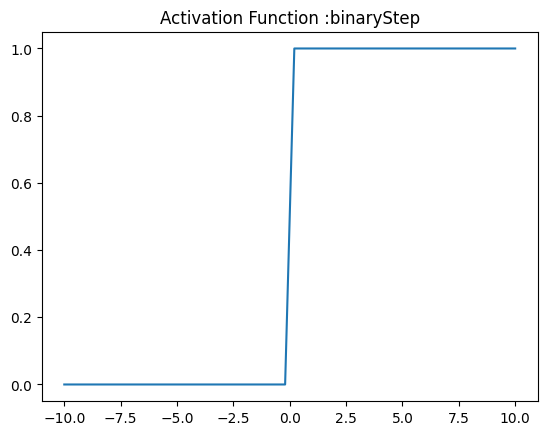

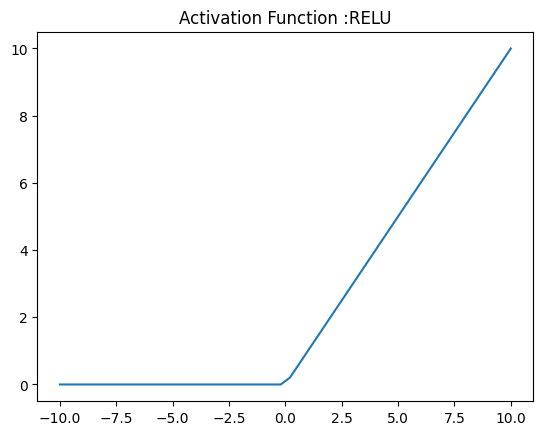

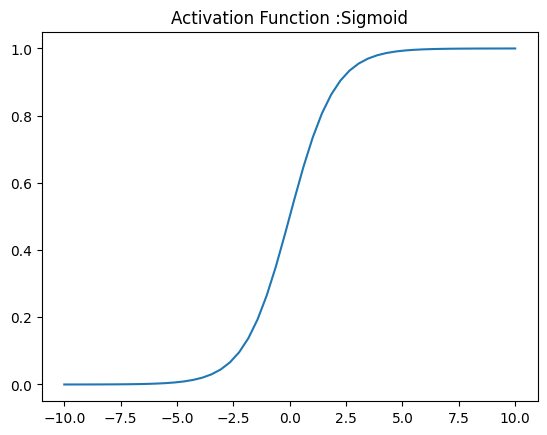

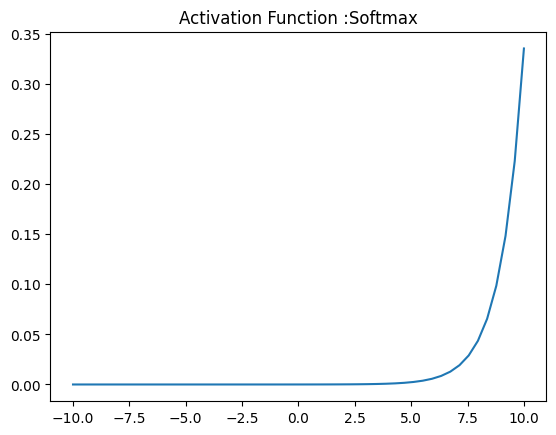

In [11]:
def binaryStep(x):
    return np.heaviside(x,1)

def RELU(x):
    x1=[]
    for i in x:
        if i<0:
            x1.append(0)
        else:
            x1.append(i)

    return x1

def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

x = np.linspace(-10, 10)
plt.plot(x, binaryStep(x))
plt.axis('tight')
plt.title('Activation Function :binaryStep')
plt.show()

plt.plot(x, RELU(x))
plt.axis('tight')
plt.title('Activation Function :RELU')
plt.show()

plt.plot(x, sigmoid(x))
plt.axis('tight')
plt.title('Activation Function :Sigmoid')
plt.show()

plt.plot(x, softmax(x))
plt.axis('tight')
plt.title('Activation Function :Softmax')
plt.show()

**3.7.3 Cost Function** - $$J =\frac{1}{2}\sum_{n=1}^N\sum_{K=1}^K\left(\hat{y_k^{(n)}}-y_k^{(n)}\right)^2$$
For a binary classification $(y^{(n)} = 0,1)$, the cost function is$$J =-\sum_{n=1}^N\left(y^{(n)}\ln\left(\hat{y_k^{(n)}}\right)+(1-y^{(n)})\ln\left(1-\hat{y_k^{(n)}}\right)\right)^2$$

In [13]:
def cost_function(AL,y):
    m=AL.shape[1]
    cost = (-1/m) * np.sum(np.multiply(y,np.log(AL)) + np.multiply((1-y),np.log(1-AL)))
    cost = np.squeeze(cost)

    return cost

def convert_prob_into_class(AL):
    pred = np.copy(AL)
    pred[AL > 0.5]  = 1
    pred[AL <= 0.5] = 0
    return pred

def get_accuracy(AL, Y):
    pred = convert_prob_into_class(AL)
    return (pred == Y).all(axis=0).mean()

test_cost=cost_function(test_AL,y)
print(test_cost)

test_y_hat=convert_prob_into_class(test_AL)
test_accuracy = get_accuracy(test_AL,y)


0.6932282197582498


**3.7.4 Backpropagation**

In [15]:
def sigmoid_backward_propagation(dA,z):
    sig=sigmoid(z)
    dz = dA * sig * (1-sig)
    return dz

def relu_backward_propagation(dA,z):
    dz = np.array(dA,copy=True)
    dz[z<=0]=0
    return dz


def single_layer_backward_propagation(dA_cur,w_cur,b_cur,z_cur,A_prev,activation):
    m=A_prev.shape[1]

    if activation == 'sigmoid':
        backward_activation_func = sigmoid_backward_propagation
    elif activation == 'relu':
        backward_activation_func = relu_backward_propagation
    else:
        raise Exception ('Not supported activation function')
    dz_cur = backward_activation_func(dA_cur,z_cur)

    dw_cur = np.dot(dz_cur,A_prev.T)/m
    db_cur = np.sum(dz_cur,axis=1,keepdims=True)/m
    dA_prev = np.dot(w_cur.T,dz_cur)

    return dA_prev, dw_cur, db_cur

def full_backward_propagation(AL,y,caches,parameters):

    grads={}
    Length = len(caches)//2
    m = AL.shape[1]
    y = y.reshape(AL.shape)

    dA_cur = - (np.divide(y,AL) - np.divide((1-y),(1-AL)))

    w_cur = parameters['w'+str(Length)]
    b_cur = parameters['b'+str(Length)]
    z_cur = caches['z'+str(Length)]
    A_prev = caches['a'+str(Length-1)]

    dA_prev, dw_cur, db_cur = single_layer_backward_propagation(dA_cur,w_cur,b_cur,z_cur,A_prev,'sigmoid')

    grads['dw'+str(Length)] = dw_cur
    grads['db'+str(Length)] = db_cur

    for i in reversed(range(1,Length)):
        dA_cur = dA_prev
        w_cur  = parameters['w'+str(i)]
        b_cur  = parameters['b'+str(i)]
        z_cur  = caches['z'+str(i)]
        A_prev = caches['a'+str(i-1)]

        dA_prev, dw_cur, db_cur = single_layer_backward_propagation(dA_cur,w_cur,b_cur,z_cur,A_prev,'relu')

        grads['dw'+str(i)]=dw_cur
        grads['db'+str(i)]=db_cur

    return grads

dA_cur = - (np.divide(y,test_AL) - np.divide((1-y),(1-test_AL)))
dA_prev,dw_cur,db_cur=single_layer_backward_propagation(dA_cur,test_parameters['w2'],test_parameters['b2'],
                                                        caches['z2'],caches['a1'],'sigmoid')
print(dw_cur)
print(db_cur)
print(dA_prev)

test_grads=full_backward_propagation(test_AL,y,caches,test_parameters)
print(test_grads['dw2'])
print(test_grads['db2'])
print(test_grads['dw1'])
print(test_grads['db1'])

[[-0.00882962  0.00701355]]
[[-0.1665338]]
[[-0.00023588 -0.00023594  0.00023607]
 [-0.00607681 -0.00607842  0.00608162]]
[[-0.00882962  0.00701355]]
[[-0.1665338]]
[[-0.00015727  0.00015734]
 [-0.0020256   0.00202721]]
[[-7.85849071e-05]
 [ 1.60253171e-06]]


**3.7.5 Backpropagation Algorithm**

In [16]:
def update_parameters(parameters,grads,learning_rate):
    Length = len(parameters)//2

    for i in (range(1,Length+1)):
        parameters['w'+str(i)] -= grads['dw'+str(i)] * learning_rate
        parameters['b'+str(i)] -= grads['db'+str(i)] * learning_rate

    return parameters

test_parameters_update = update_parameters(test_parameters,test_grads,1)
print(test_parameters_update['w1'])
print(test_parameters_update['b1'])
print(test_parameters_update['w2'])
print(test_parameters_update['b2'])

[[0.05449777 0.0276796 ]
 [0.04447736 0.08245041]]
[[ 7.85849071e-05]
 [-1.60253171e-06]]
[[0.00930151 0.00514336]]
[[0.1665338]]


In [19]:
def train_model(X,y,epoch,layer_dim,learning_rate):
    cost_history = []
    accuracy_history = []
    epoches=[]
    parameters = initialize_parameters(layer_dim)

    for i in range(1,epoch):
        AL, caches = full_forward_propagation(X,parameters)

        cost = cost_function(AL,y)
        cost_history.append(cost)

        accuracy =get_accuracy(AL,y)
        accuracy_history.append(accuracy)

        epoches.append(i)
        grads = full_backward_propagation(AL,y,caches,parameters)

        parameters = update_parameters(parameters,grads,learning_rate)

    return parameters,cost_history, accuracy_history, epoches

from sklearn.datasets import make_moons
N_SAMPLES = 1000
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)

test_parameters,test_cost,test_accuracy,test_epoches=train_model(X.T, y, 10000, [2,25,100,100,10,1],0.01)

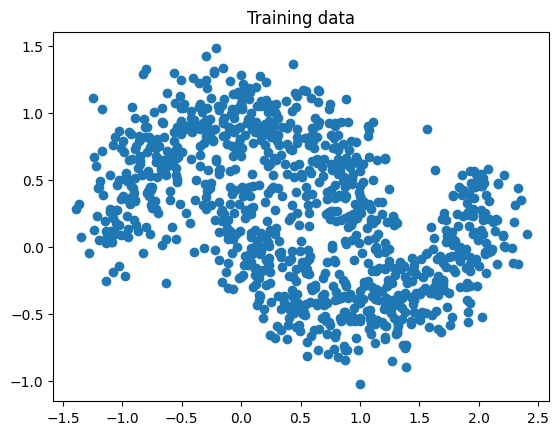

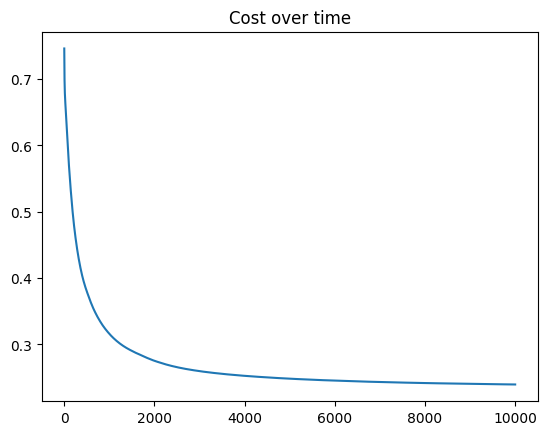

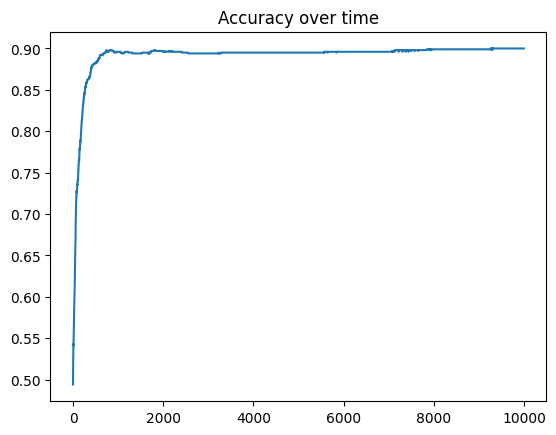

In [20]:
a = [row[0] for row in X]
b = [row[1] for row in X]
plt.scatter(a, b)
plt.axis('tight')
plt.title('Training data')
plt.show()

x = np.linspace(0,10000,num=9999)
plt.plot(x, test_cost)
plt.axis('tight')
plt.title('Cost over time')
plt.show()

plt.plot(x, test_accuracy)
plt.axis('tight')
plt.title('Accuracy over time')
plt.show()

Source: [madonnajorin](https://github.com/madonnaojorin/MAT494/blob/main/3.5_K_means_3.6_Support_Vector_Machine.ipynb)